МАРТИРОСЯН ЗАВЕН
martirosian.z@mail.ru
https://stepik.org/users/22730977

<img src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500, height=450>
<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

---

<b> Прочитайте семинар, пожалуйста, для успешного выполнения домашнего задания

## Задача поиска схожих по смыслу предложений

Мы будем ранжировать вопросы [StackOverflow](https://stackoverflow.com) на основе семантического векторного представления 

До этого в курсе не было речи про задачу ранжировния, поэтому введем математическую формулировку

## Задача ранжирования(Learning to Rank)

* $X$ - множество объектов
* $X^l = \{x_1, x_2, ..., x_l\}$ - обучающая выборка
<br>На обучающей выборке задан порядок между некоторыми элементами, то есть нам известно, что некий объект выборки более релевантный для нас, чем другой:
* $i \prec j$ - порядок пары индексов объектов на выборке $X^l$ c индексами $i$ и $j$
### Задача:
построить ранжирующую функцию $a$ : $X \rightarrow R$ такую, что
$$i \prec j \Rightarrow a(x_i) < a(x_j)$$

<img src="https://d25skit2l41vkl.cloudfront.net/wp-content/uploads/2016/12/Featured-Image.jpg" width=500, height=450>

### Данные
`test.tsv` - тестовая выборка. В каждой строке через табуляцию записаны: *<вопрос>, <похожий вопрос>, <отрицательный пример 1>, <отрицательный пример 2>, ...*

Будем использовать предобученные векторные представления слов [GoogleNews-vectors-negative300](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit) (<b>скачаем их</b>), которые были обучены с помощью стандартной модели word2vec на данных Google News (100 миллиардов слов). Модель содержит 300-мерные вектора для 3 миллионов слов и фраз

<b>Загрузим</b> их после <b>скачивания</b> с помощью функции [KeyedVectors.load_word2vec_format](https://radimrehurek.com/gensim/models/keyedvectors.html) библиотеки Gensim, с которой вы познакомились на семинаре. Загрузим только часть векторов, указав параметр *limit* = 500000.

In [1]:
import torch
torch.cuda.get_device_name(0)

'Tesla P4'

In [2]:
!wget -c 'https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz'

--2020-04-05 17:03:26--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.227.163
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.227.163|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [0]:
import gensim

In [4]:
wv_embeddings = gensim.models.KeyedVectors.load_word2vec_format(fname='GoogleNews-vectors-negative300.bin.gz', limit=500000, binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


### Как пользоваться этими векторами?

Посмотрим на примере одного слова, что из себя представляет embedding

In [5]:
word = 'dog'
if word in wv_embeddings:
    print(wv_embeddings[word].dtype, wv_embeddings[word].shape)

float32 (300,)


<b>Еще раз напомню, что семинар нужно прочитать

Найдем наиболее близкие слова к слову `dog`:

In [6]:
wv_embeddings.most_similar(positive='dog')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('dogs', 0.8680489659309387),
 ('puppy', 0.8106428384780884),
 ('pit_bull', 0.780396044254303),
 ('pooch', 0.7627377510070801),
 ('cat', 0.7609456777572632),
 ('golden_retriever', 0.7500902414321899),
 ('German_shepherd', 0.7465174198150635),
 ('Rottweiler', 0.7437614798545837),
 ('beagle', 0.7418621778488159),
 ('pup', 0.740691065788269)]

### Вопрос 1:
* Входит ли слов `cat` топ-5 близких слов к слову `dog`?

In [7]:
wv_embeddings.most_similar(positive='dog',topn=5 )

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('dogs', 0.8680489659309387),
 ('puppy', 0.8106428384780884),
 ('pit_bull', 0.780396044254303),
 ('pooch', 0.7627377510070801),
 ('cat', 0.7609456777572632)]

Ответ: Да, входит

### Векторные представления текста

Перейдем от векторных представлений отдельных слов к векторным представлениям вопросов, как к **среднему** векторов всех слов в вопросе. Если для какого-то слова нет предобученного вектора, то его нужно пропустить. Если вопрос не содержит ни одного известного слова, то нужно вернуть нулевой вектор.

In [0]:
import numpy as np
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

In [0]:
def question_to_vec(question, embeddings, dim=300):
    """
        question: строка
        embeddings: наше векторное представление
        dim: размер любого вектора в нашем представлении
        
        return: векторное представление для вопроса
    """
    # убрать знак вопроса, если он есть
    words = tokenizer.tokenize(question)
    n_known = 0
    result = np.array([0] * dim, dtype=float)
    
    for word in words:
        if word in embeddings:
            result += embeddings[word]
            n_known += 1
            
    if n_known != 0:
        return result/n_known
    else:
        return result

Теперь у нас есть метод для создания векторного представления любого предложения.

In [10]:
question_to_vec('What is your name?', wv_embeddings)

array([ 0.08168793,  0.08300781,  0.11901855,  0.14401245, -0.20117188,
        0.07421875,  0.05730057, -0.10681152,  0.05529785,  0.04562378,
        0.00805664, -0.08691406, -0.05615234,  0.0378418 , -0.14160156,
        0.21166992,  0.02227783,  0.1038208 ,  0.05236816, -0.06506348,
       -0.01171875,  0.11782837,  0.08465576, -0.03713989, -0.0637455 ,
        0.06387329, -0.09069824,  0.09814453,  0.05462074,  0.00167847,
        0.05584717, -0.0502224 ,  0.01148987,  0.02403259,  0.0269165 ,
        0.06005859,  0.00256348,  0.13464355,  0.07763672,  0.00631714,
       -0.04569244, -0.003479  ,  0.09146118,  0.01768494,  0.04992676,
       -0.00471497, -0.00518036,  0.04821777,  0.01062012, -0.03045654,
       -0.13549805,  0.13912964,  0.04402161, -0.08166504,  0.16625977,
        0.05966187, -0.03668213, -0.0868454 ,  0.16571045,  0.02966309,
        0.01908493,  0.0509491 , -0.07147217, -0.02941895, -0.04200745,
       -0.04049683,  0.05050659,  0.02288818, -0.0723877 , -0.02

### Оценка близости текстов

Представим, что мы используем идеальные векторные представления слов. Тогда косинусное расстояние между дублирующими предложениями должно быть меньше, чем между случайно взятыми предложениями. 

Сгенерируем для каждого из $N$ вопросов $R$ случайных отрицательных примеров и примешаем к ним также настоящие дубликаты. Для каждого вопроса будем ранжировать с помощью нашей модели $R + 1$ примеров и смотреть на позицию дубликата. Мы хотим, чтобы дубликат был первым в ранжированном списке.

#### Hits@K
Первой простой метрикой будет количество корректных попаданий для какого-то $K$:
$$ \text{Hits@K} = \frac{1}{N}\sum_{i=1}^N \, [rank\_q_i^{'} \le K],$$
* $q_i$ - $i$-ый вопрос
* $q_i^{'}$ - его дубликат
* $rank\_q_i^{'}$ - позиция дубликата в ранжированном списке ближайших предложений для вопроса $q_i$.

#### DCG@K
Второй метрикой будет упрощенная DCG метрика, учитывающая порядок элементов в списке путем домножения релевантности элемента на вес равный обратному логарифму номера позиции::
$$ \text{DCG@K} = \frac{1}{N} \sum_{i=1}^N\frac{1}{\log_2(1+rank\_q_i^{'})}\cdot[rank\_q_i^{'} \le K],$$
С такой метрикой модель штрафуется за низкую позицию корректного ответа

<img src='https://hsto.org/files/1c5/edf/dee/1c5edfdeebce4b71a86bdf986d9f88f2.jpg' width=400, height=200>

#### Пример оценок

Вычислим описанные выше метрики для игрушечного примера. 
Пусть
* $N = 1$, $R = 3$
* <font color='green'>"Что такое python"</font> - вопрос $q_1$
* <font color='red'>"Что такое язык python"</font> - его дубликат $q_i^{'}$

Пусть модель выдала следующий ранжированный список кандидатов:

1. *"Как узнать с++"*
2. <font color='red'>*"Что такое язык python"*</font>
3. *"Хочу учить Java"*
4. *"Не понимаю Tensorflow"*

$\Rightarrow rank\_q_i^{'} = 2$

Вычислим метрику *Hits@K* для *K = 1, 4*:

- [K = 1] $\text{Hits@1} =  [rank\_q_i^{'} \le 1] = 0$
- [K = 4] $\text{Hits@4} =  [rank\_q_i^{'} \le 4] = 1$

Вычислим метрику *DCG@K* для *K = 1, 4*:
- [K = 1] $\text{DCG@1} = \frac{1}{\log_2(1+2)}\cdot[2 \le 1] = 0$
- [K = 4] $\text{DCG@4} = \frac{1}{\log_2(1+2)}\cdot[2 \le 4] = \frac{1}{\log_2{3}}$

### HITS\_COUNT и DCG\_SCORE

Каждая функция имеет два аргумента: $dup\_ranks$ и $k$. $dup\_ranks$ является списком, который содержит рейтинги дубликатов $rank\_q_i^{'}$(их позиции в ранжированном списке). Например, $dup\_ranks = [2]$ для примера, описанного выше.

In [0]:
def hits_count(dup_ranks, k):
    """
        result: вернуть  Hits@k
    """
    N = len(dup_ranks)
    num = 0
    for i in dup_ranks:
      if i <= k:
        num += 1    
    hits_value = (1/N)*num
    return hits_value    

In [0]:
def dcg_score(dup_ranks, k):
    """
        result: вернуть DCG@k
    """
    new_dup_ranks = np.array(dup_ranks)
    N = len(dup_ranks)
    num=0;
    for i in dup_ranks:
      if i <= k:
        num=num+1/(np.log2(1+i))
    dcg_value = num/N
    return dcg_value

Протестируем функции. Пусть $N = 1$, то есть один эксперимент. Будем искать копию вопроса и оценивать метрики.

In [0]:
import pandas as pd

In [14]:
copy_answers = ["How does the catch keyword determine the type of exception that was thrown"]

# наги кандидаты
candidates_ranking = [["How Can I Make These Links Rotate in PHP",
                       "How does the catch keyword determine the type of exception that was thrown",
                       "NSLog array description not memory address",
                       "PECL_HTTP not recognised php ubuntu"]]
# dup_ranks — позиции наших копий, так как эксперимент один, то этот массив длины 1
dup_ranks = [candidates_ranking[0].index(copy_answers[i]) + 1 for i in range(len(copy_answers))]

# вычисляем метрику для разных k
print('Ваш ответ HIT:', [hits_count (dup_ranks,k) for k in range(1, 5)])
print('Ваш ответ DCG:', [round( dcg_score (dup_ranks,k) , 5) for k in range(1, 5)])

Ваш ответ HIT: [0.0, 1.0, 1.0, 1.0]
Ваш ответ DCG: [0.0, 0.63093, 0.63093, 0.63093]


У вас должно получиться

In [15]:
# correct_answers - метрика для разных k
correct_answers = pd.DataFrame([[0, 1, 1, 1], [0, 1 / (np.log2(3)), 1 / (np.log2(3)), 1 / (np.log2(3))]],
                               index=['HITS', 'DCG'], columns=range(1,5))
correct_answers

,1,2,3,4
HITS,0,1.00000,1.00000,1.00000
DCG,0,0.63093,0.63093,0.63093


### Ранжирование вопросов StackOverflow

- *тестовая* выборка (test.tsv) содержит в каждой строке: *вопрос, похожий вопрос, отрицательный пример 1, отрицательный пример 2, ...*
TEST!!!

Считаем тестовую выборку для оценки качества текущего решения.

In [0]:
def read_corpus(filename):
    data = []
    for line in open(filename, encoding='utf-8'):
        data.append(line.strip().split('\t'))
    return data

In [17]:
!gdown https://drive.google.com/uc?id=12VAWjs-kvpgapurkuURus7E53F711uFV&export=download
# или скачайте по ссылке https://drive.google.com/uc?id=12VAWjs-kvpgapurkuURus7E53F711uFV

Downloading...
From: https://drive.google.com/uc?id=12VAWjs-kvpgapurkuURus7E53F711uFV
To: /content/test.tsv
201MB [00:02, 76.7MB/s]


In [0]:
test = read_corpus('test.tsv')

Кол-во строк

In [19]:
len(test)

3760

Размер нескольких первых строк

In [20]:
for i in range(5):
    print(i + 1, len(test[i]))

1 1001
2 1001
3 1001
4 1001
5 1001


Реализуйте функцию ранжирования кандидатов на основе косинусного расстояния. Функция должна по списку кандидатов вернуть отсортированный список пар (позиция в исходном списке кандидатов, кандидат). При этом позиция кандидата в полученном списке является его рейтингом (первый - лучший). Например, если исходный список кандидатов был [a, b, c], и самый похожий на исходный вопрос среди них - c, затем a, и в конце b, то функция должна вернуть список *[(2, c), (0, a), (1, b)]*.

In [0]:
from sklearn.metrics.pairwise import cosine_similarity
from copy import deepcopy

In [0]:
def rank_candidates(question, candidates, embeddings, dim=300):
    """
        question: строка
        candidates: массив строк(кандидатов) [a, b, c]
        result: пары (начальная позиция, кандидат) [(2, c), (0, a), (1, b)]
    """
    vec_question = question_to_vec(question, embeddings)
    vec_candidates = np.array([question_to_vec(candidates[i] ,embeddings )
                      for i in range(len(candidates))])
    rank_candidates = np.array([(i, candidates[i]) for i in range(len(candidates))])
    # ранжирование
    dist_s = cosine_similarity(vec_candidates, np.array([vec_question]))[:, 0]
    return deepcopy(rank_candidates[dist_s.argsort()[::-1]])

Протестируйте работу функции на примерах ниже. Пусть $N=2$, то есть два эксперимента

In [0]:
questions = ['converting string to list', 'Sending array via Ajax fails'] 

candidates = [['Convert Google results object (pure js) to Python object', # первый эксперимент
               'C# create cookie from string and send it',
               'How to use jQuery AJAX for an outside domain?'],
              
              ['Getting all list items of an unordered list in PHP',      # второй эксперимент
               'WPF- How to update the changes in list item of a list',
               'select2 not displaying search results']]

In [24]:
for question, q_candidates in zip(questions, candidates):
        ranks = rank_candidates(question, q_candidates, wv_embeddings, 300)
        print(ranks)
        print()


[['1' 'C# create cookie from string and send it']
 ['0' 'Convert Google results object (pure js) to Python object']
 ['2' 'How to use jQuery AJAX for an outside domain?']]

[['0' 'Getting all list items of an unordered list in PHP']
 ['2' 'select2 not displaying search results']
 ['1' 'WPF- How to update the changes in list item of a list']]



Для первого экперимента вы можете полностью сравнить ваши ответы и правильные ответы. Но для второго эксперимента два ответа на кандидаты будут <b>скрыты</b>(*)

In [0]:
# должно вывести
results = [[(1, 'C# create cookie from string and send it'),
            (0, 'Convert Google results object (pure js) to Python object'),
            (2, 'How to use jQuery AJAX for an outside domain?')],
           [(0, 'Getting all list items of an unordered list in PHP'),
            (*, 'select2 not displaying search results'), #скрыт
            (*, 'WPF- How to update the changes in list item of a list')]] #скрыт

Последовательность начальных индексов вы должны получить `для экспереминта 1`  1, 0, 2. Для второго экперимента вы знаете один индекс уже.

Теперь мы можем оценить качество нашего метода. Запустите следующие два блока кода для получения результата. Обратите внимание, что вычисление расстояния между векторами занимает некоторое время (примерно 10 минут).

In [0]:
wv_ranking = []
for line in test:
    q, *ex = line
    ranks = rank_candidates(q, ex, wv_embeddings)
    wv_ranking.append([r[0] for r in ranks].index('0') + 1)

In [27]:
for k in [1, 5, 10, 100, 500, 1000]:
    print("DCG@%4d: %.3f | Hits@%4d: %.3f" % (k, dcg_score(wv_ranking, k), k, hits_count(wv_ranking, k)))

DCG@   1: 0.259 | Hits@   1: 0.259
DCG@   5: 0.314 | Hits@   5: 0.364
DCG@  10: 0.332 | Hits@  10: 0.420
DCG@ 100: 0.374 | Hits@ 100: 0.627
DCG@ 500: 0.401 | Hits@ 500: 0.840
DCG@1000: 0.418 | Hits@1000: 1.000


Если вы проделали все шаги правильно, то вы должны немного разочароваться полученными результатами. Давайте попробуем понять, почему качество модели такое низкое. Когда вы работаете с какими-либо данными, очень полезно первым делом посмотреть на них глазами. Выведим несколько вопросов из наших данных:

In [28]:
for line in test[:3]:
    q, *examples = line
    print(q, *examples[:3])
    print()

How to print a binary heap tree without recursion? How do you best convert a recursive function to an iterative one? How can i use ng-model with directive in angular js flash: drawing and erasing

How to start PhoneStateListener programmatically? PhoneStateListener and service Java cast object[] to model WCF and What does this mean?

jQuery: Show a div2 when mousenter over div1 is over when hover on div1 depenting on if it is on div2 or not it should act differently How to run selenium in google app engine/cloud? Python Comparing two lists of strings for similarities



Как вы можете заметить, мы имеем дело с сырыми данными. Это означает, что там присутствует много опечаток, спецсимволов и заглавных букв. В нашем случае это все может привести к ситуации, когда для данных токенов нет предобученных векторов. Поэтому необходима предобработка.

Реализуйем функцию предобработки текстов. Вам требуется:
- Перевести символы в нижний регистр;
- Заменить символы пунктуации на пробелы;
- Удалить "плохие" символы;
- Удалить стопслова.

In [29]:
import re
import nltk
import string
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Кол-во стоп стопслов

In [30]:
stopWords = set(stopwords.words('english'))
len(stopWords)

179

In [0]:
def text_prepare(text):
    """
        text: a string
        return: modified string
    """
    # Перевести символы в нижний регистр
    text = text.lower()
    
    # Заменить символы пунктуации на пробелы
    text = re.sub(r'[{}]'.format(string.punctuation), ' ', text)
    
    # Удалить "плохие" символы
    text = re.sub('[^A-Za-z0-9 ]', '', text)
    
    # Удалить стопслова.
    stopWords = set(stopwords.words('english'))
    for stopWord in stopWords:
        text = re.sub(r'\b{}\b'.format(stopWord), '', text)
    return text

Теперь преобразуйте все вопросы из тестовой выборки. Оцените, как изменилось качество. Сделайте выводы. Для изменения текста понадобиться около 30 минут.

In [31]:
from tqdm import tqdm_notebook
from copy import deepcopy
new_test = deepcopy(test)
for i in tqdm_notebook(range(len(test))):
    for j in range(len(test[i])):
        new_test[i][j] = text_prepare(test[i][j])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [0]:
wv_ranking = []
for line in new_test:
    q, *ex = line
    ranks = rank_candidates(q, ex, wv_embeddings)
    wv_ranking.append([r[0] for r in ranks].index('0') + 1)

In [34]:
for k in [1, 5, 10, 100, 500, 1000]:
    print("DCG@%4d: %.3f | Hits@%4d: %.3f" % (k, dcg_score(wv_ranking, k), k, hits_count(wv_ranking, k)))

DCG@   1: 0.340 | Hits@   1: 0.340
DCG@   5: 0.412 | Hits@   5: 0.477
DCG@  10: 0.427 | Hits@  10: 0.523
DCG@ 100: 0.463 | Hits@ 100: 0.702
DCG@ 500: 0.482 | Hits@ 500: 0.855
DCG@1000: 0.498 | Hits@1000: 1.000


# Finally!.. Visualization! (Again..)

Раз уж мы научились получать эмбеддинги предложений, а не только слов, давайте попробуем визуализировать эмбеддинги предложений!

Функция получения эмбеддинга по предложению у нас уже есть (question_to_vec в начале ноутбука). Нам осталось выбрать, какой датасет мы будем использовать (quora.txt с семинара или stackoverflow из этого дз), и далее:

1. Проделать предобработку вопросов (text_prepare, как выше)
2. Для всех вопросов получить эмбединнги (question_to_vec)
3. Применить к массиву эмбеддингов TSNE (как на семинаре)
4. Не забыть нормализовать векторы, полученные из TSNE
5. Запустить функцию draw из семинара!

In [0]:
# download and unpack tsnecuda from anaconda.org

!wget https://anaconda.org/CannyLab/tsnecuda/2.1.0/download/linux-64/tsnecuda-2.1.0-cuda100.tar.bz2
!tar xvjf tsnecuda-2.1.0-cuda100.tar.bz2
!cp -r site-packages/* /usr/local/lib/python3.6/dist-packages/

In [33]:
# create a symbolic link between the downloaded libfaiss.so file and the location python's looking at
!echo $LD_LIBRARY_PATH 
# this is probably /usr/lib64-nvidia
!ln -s /content/lib/libfaiss.so $LD_LIBRARY_PATH/libfaiss.so

/usr/lib64-nvidia
ln: failed to create symbolic link '/usr/lib64-nvidia/libfaiss.so': File exists


In [0]:
!wget -O quora.txt https://www.dropbox.com/s/obaitrix9jyu84r/quora.txt?dl=1

In [0]:
quora = list(open("./quora.txt"))

In [36]:
from tqdm import tqdm_notebook
new_quora=deepcopy(quora)
for i in tqdm_notebook(range(len(quora))):
  new_quora[i] = text_prepare(quora[i])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
def questions_to_vec(questions, embeddings, dim=300):
    """
        questions: строка
    """
    vec_questions = np.array([question_to_vec(questions[i] ,embeddings)
                      for i in range(len(questions))])
    return vec_questions

In [0]:
questions_vec=questions_to_vec(new_quora, wv_embeddings)

In [0]:
from sklearn.manifold import TSNE
from tsnecuda import TSNE as TSNE_CUDA
from time import perf_counter

tsne_cuda = TSNE_CUDA(n_components=2)

In [0]:
embeddings_gpu = tsne_cuda.fit_transform(questions_vec)

In [0]:
from sklearn.preprocessing import StandardScaler
ss=StandardScaler()
embeddings_gpu_ss=ss.fit_transform(embeddings_gpu)

In [62]:
import bokeh.models as bm, bokeh.plotting as pl
from bokeh.io import output_notebook
output_notebook()

def draw_vectors(x, y, radius=2, alpha=0.4, color='blue',
                 width=600, height=400, show=True, **kwargs):
    if isinstance(color, str): color = [color] * len(x)
    data_source = bm.ColumnDataSource({ 'x' : x, 'y' : y, 'color': color, **kwargs })

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show: pl.show(fig)
    return fig


draw_vectors(embeddings_gpu_ss[:25000, 0], embeddings_gpu_ss[:25000, 1], token=new_quora[:25000])

Figure(id='1225', ...)

## Скриншот с результатом

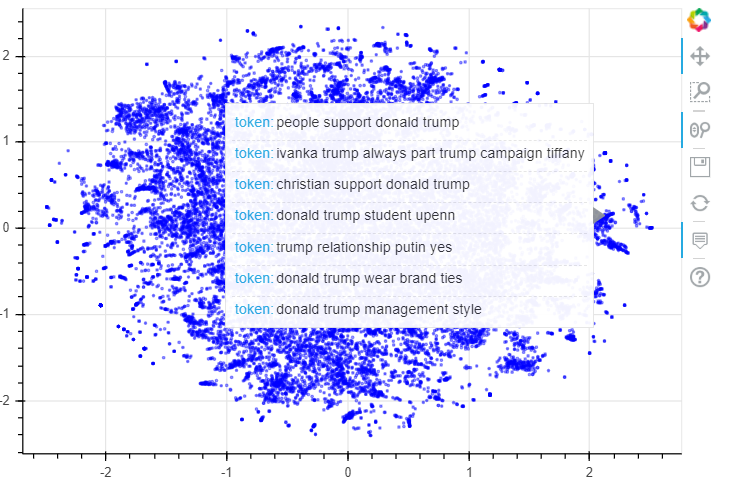

Отлично. Но, к сожалению, визуализацию тестами на канвасе проверить нельзя, поэтому давайте еще напишем функцию, которая будет находить к вопросу ближайшие похожие =)

In [0]:
def find_closest_questions(question, questions_emb, embeddings, questions, k=5):
    """
    function that finds closest questions from dataset given question
    args:
        question: question, preprocessed using text_prepare 
        k: how many nearest questions to find
    """
    vec_question = question_to_vec(question, embeddings)
    dist_s = cosine_similarity(questions_emb, np.array([vec_question]))[:, 0]
    sorted_dist_s=sorted(dist_s)[::-1][:k]
    idx_sorted_dist_s=dist_s.argsort()[::-1]
    sorted_questions=np.array(questions)[idx_sorted_dist_s.tolist()][:k]
    result=dict(zip(sorted_questions, sorted_dist_s ))
    return result

### Вопрос 10:
* Какой самый ближайший вопрос к "Why am I so stupid?"?
В канвас напишите слова вопроса с маленькой буквы через пробелы без знаков пунктуации (только латинские буквы)

In [61]:
find_closest_questions(question=text_prepare("Why am I so stupid?"), questions_emb = questions_vec, embeddings = wv_embeddings, questions=quora)

{'How can I be so stupid?\n': 1.0000000000000002,
 'How do I be stupid?\n': 1.0000000000000002,
 'How not to be stupid?\n': 1.0000000000000002,
 'Stupid is as stupid does?\n': 1.0000000000000002,
 'Why am I stupid?\n': 1.0000000000000002}